In [1]:
import gym
import matplotlib.pyplot as plt
import seaborn as sns

from fluri.sumo.sumo_gym import SumoGym
from fluri.sumo.sumo_sim import SumoSim
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from os.path import join

GRID_SHAPE = (50, 50)

In [2]:
data = None
def init_data() -> None:
    global data
    data = {
        "action": [],
        "step": [],
        "policy": []
    }

def add_record(action, step, policy) -> None:
    global data
    data["action"].append(action[0])
    data["step"].append(step)
    data["policy"].append(policy)

In [3]:
def train() -> None:
    path = join("configs", "example")
    sim = SumoSim(config = {
        "gui": False,
        "net-file": join(path, "traffic.net.xml"),
        "route-files": join(path, "traffic.rou.xml"),
        "additional-files": join(path, "traffic.det.xml"),
        "tripinfo-output": join(path, "tripinfo.xml")
    })
    
    init_data()
    env = SumoGym(sim, grid_shape=GRID_SHAPE)
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=int(2e4)) ## NOTE: Should take a while.
    return model

In [4]:
model = train()
model.policy.save("trained_model")
# model = PPO.load("trained_model")

 Retrying in 1 seconds
Using cpu device
Wrapping the env in a DummyVecEnv.


AssertionError: You should use NatureCNN only with images not with Box(50, 50) (you are probably using `CnnPolicy` instead of `MlpPolicy`)

In [5]:
def test() -> None:
    path = join("configs", "example")
    sim = SumoSim(config={
        "gui": True,
        "net-file": join(path, "traffic.net.xml"),
        "route-files": join(path, "traffic.rou.xml"),
        "additional-files": join(path, "traffic.det.xml"),
        "tripinfo-output": join(path, "tripinfo.xml")
    })
    
    init_data()
    env = SumoGym(sim, grid_shape=GRID_SHAPE)

    ## Random Policy.
    obs = env.reset()
    done, step = False, 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        add_record(info["taken_action"], step, "random")
        step += 1
        add_record(info["taken_action"], step, "random")

    ## RL Policy.
    obs = env.reset()
    done, step = False, 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        add_record(info["taken_action"], step, "RL")
        step += 1
        add_record(info["taken_action"], step, "RL")
    env.close()
    
    sns.lineplot(x="step", y="action", hue="policy", style="policy", data=data)
    plt.show()

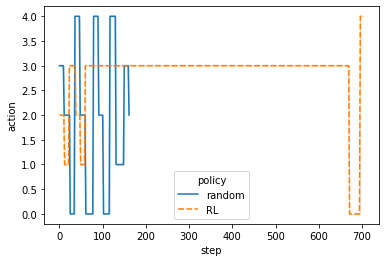

In [6]:
test()